In [6]:
import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time
from scipy.cluster.hierarchy import dendrogram, linkage

In [7]:
def load_graph(graph_file):
    print(f"Loading graph from {graph_file}...")
    start_time = time.time()
    
    # Load the graph
    G = nx.read_graphml(graph_file)
    
    # Convert position strings back into lists of integers
    for node in G.nodes:
        pos_str = G.nodes[node].get('pos', '')  # Use .get to avoid KeyError if 'pos' does not exist
        if pos_str:  # Check if the position string is not empty
            G.nodes[node]['pos'] = list(map(int, pos_str.split(',')))
        else:
            G.nodes[node]['pos'] = []

    end_time = time.time()
    print(f"Graph loaded in {end_time - start_time:.2f} seconds. It has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

In [28]:
# Function to compute the partition with the Louvain method and build a dendrogram
def louvain_hierarchy(G):
    # Compute the initial partition
    partition = community_louvain.best_partition(G)
    dendro = [partition]

    # Build the hierarchy by iteratively applying Louvain method
    current_partition = partition.copy()
    level = 0
    while level < 10:
        level += 1
        # Build the induced graph from the current partition
        induced_graph = community_louvain.induced_graph(current_partition, G)
        # Compute the new partition on the induced graph
        new_partition = community_louvain.best_partition(induced_graph)

        # Map partition from the induced graph back to the original graph
        for node, community in current_partition.items():
            current_partition[node] = new_partition[community]

        dendro.append(current_partition.copy())

    return dendro

def visualize_partitions(G, dendro):
    # Determine the number of levels
    num_levels = len(dendro)

    # Prepare the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Assign a unique color to each community at the lowest level
    colors = plt.cm.tab20(np.linspace(0, 1, len(set(dendro[-1].values()))))

    # Map each node to a color based on its community at the lowest level
    color_map = {node: colors[community] for node, community in dendro[-1].items()}

    # Visualize each level
    for level, partition in enumerate(dendro):
        # Calculate position for each node at this level (simple horizontal layout)
        pos = {node: (i, -level) for i, (node, community) in enumerate(partition.items())}

        # Draw nodes and edges based on the partition
        nx.draw_networkx_nodes(G, pos, node_color=[color_map[node] for node in G.nodes()], alpha=0.5**(num_levels-level))
        nx.draw_networkx_edges(G, pos, alpha=0.5**(num_levels-level+1))

    plt.axis('off')
    plt.show()


In [10]:
G = load_graph("spotify_AugWeek1.graphml")

Loading graph from spotify_AugWeek1.graphml...
Graph loaded in 5.08 seconds. It has 5420 nodes and 114579 edges.


In [24]:
dendro = louvain_hierarchy(G)

This approach to creating a dendrogram is illustrative and simplifies the process for demonstration purposes. The dendrogram generated here does not convey the exact hierarchical clustering in a traditional sense but rather shows the hierarchy of communities merged at each level of the Louvain method's application.

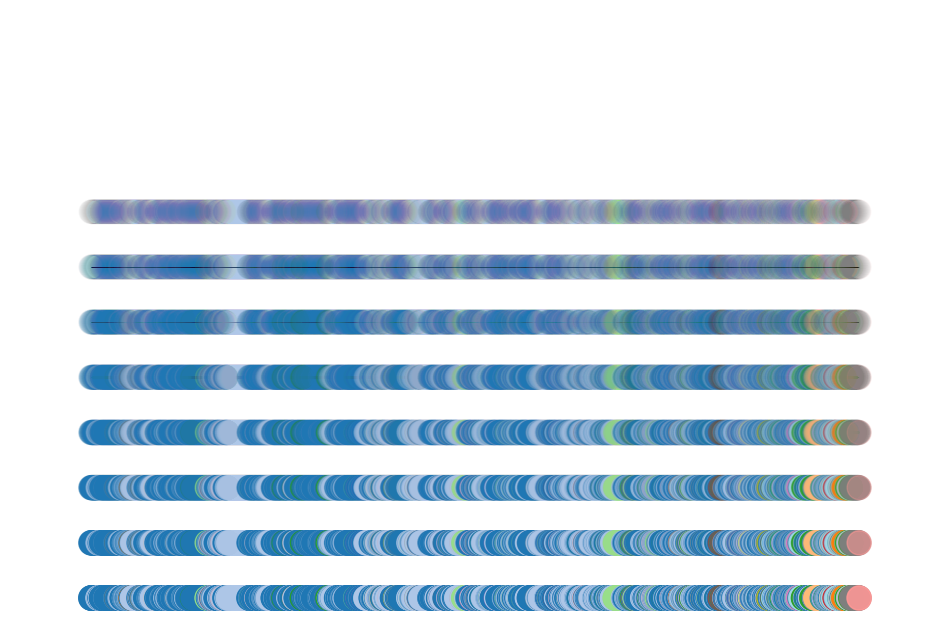

In [27]:
# Generate the linkage matrix and plot the dendrogram
visualize_partitions(G, dendro)